In [1]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('../datasets/groovy-1_6_BETA_1.csv')
df = df.drop(columns=['HeuBug', 'HeuBugCount', 'RealBugCount'])

### Split Train/Test 80/20

In [2]:
# split train and test
from sklearn.model_selection import train_test_split

X = df.drop(columns=['RealBug'])
y = df['RealBug']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train_numeric = X_train.select_dtypes(include=['float64', 'int64'])

In [3]:
print(X_train.shape)
print(X_test.shape)

(656, 66)
(165, 66)


## Balanceo de clases usando HCBOU

### Configuración de hiperparámetros HCBOU

In [4]:
import sys
sys.path.append('../utils')

%load_ext autoreload
%autoreload 2
from hcbou import hcbou_balance, get_recommended_params

print("="*50)

# Obtener parámetros recomendados para nuestro dataset
recommended_params = get_recommended_params(X_train_numeric, y_train, scenario='binary_classification')
print(f"Parámetros recomendados: {recommended_params}")

X_train_balanced, y_train_balanced = hcbou_balance(
    X_train_numeric, 
    y_train,
    **recommended_params,
    random_state=42,
    verbose=True
)

Parámetros recomendados: {'max_clusters_maj': 8, 'max_clusters_min': 6, 'k_smote': 3, 'min_cluster_obs': 5}
🚀 HCBOU BALANCING PIPELINE
Original distribution:
  Majority class (False): 600 samples
  Minority class (True): 56 samples
  Imbalance ratio: 1:10.71

📉 Step 1: Majority Class Undersampling
----------------------------------------
Applying majority class undersampling...
Majority class: 600 -> 328 samples
Reduction: 54.7%

📈 Step 2: Minority Class Clustering & SMOTE
---------------------------------------------
Finding optimal clusters for minority class...
No valid clusters found. Using single cluster.
Applying SMOTE balancing to minority class...
Cluster distribution: {0: 56}
Cluster weights: {0: 1.0}
Cluster 0: 56 -> 328 samples
Minority class: 56 -> 328 samples
Change: 585.7%

🔄 Step 3: Combining Balanced Classes
-----------------------------------

✅ HCBOU BALANCING COMPLETED
Final distribution:
  Class False: 328 samples
  Class True: 328 samples
Total samples: 656
Balance

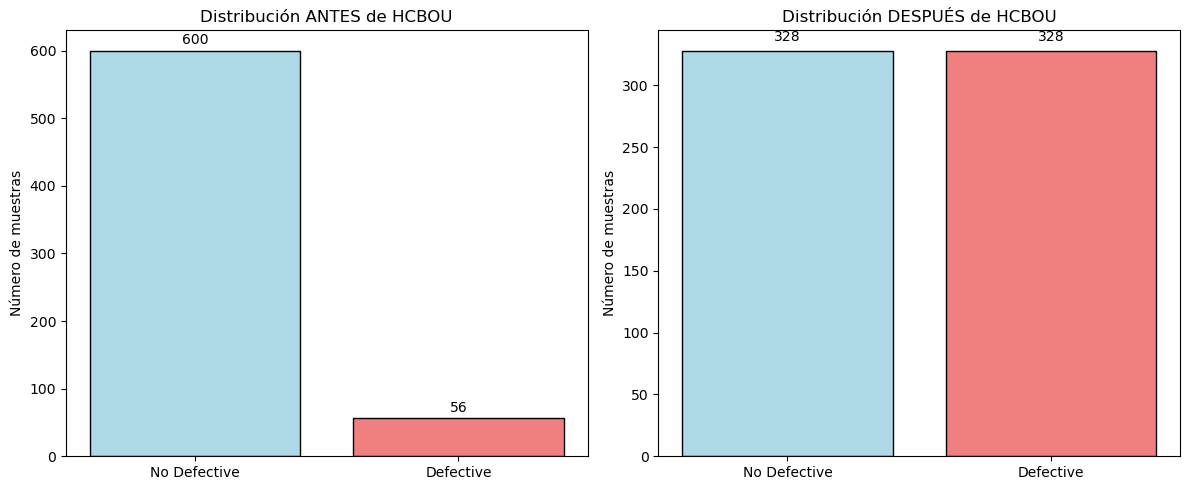


Verificación de calidad de datos balanceados:
Valores nulos en X_train_balanced: 0
Valores infinitos en X_train_balanced: 0
Shape final X_train_balanced: (656, 65)
Shape final y_train_balanced: (656,)


In [5]:
# Visualización de la distribución antes y después del balanceo
from matplotlib import pyplot as plt
import numpy as np

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Antes del balanceo
before_counts = y_train.value_counts().sort_index()
bars1 = ax1.bar(['No Defective', 'Defective'], before_counts.values, 
                color=['lightblue', 'lightcoral'], edgecolor='black')
ax1.set_title('Distribución ANTES de HCBOU')
ax1.set_ylabel('Número de muestras')
for i, bar in enumerate(bars1):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{int(height)}', ha='center', va='bottom')

# Después del balanceo
after_counts = y_train_balanced.value_counts().sort_index()
bars2 = ax2.bar(['No Defective', 'Defective'], after_counts.values,
                color=['lightblue', 'lightcoral'], edgecolor='black')
ax2.set_title('Distribución DESPUÉS de HCBOU')
ax2.set_ylabel('Número de muestras')
for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Verificar que no hay valores nulos en los datos balanceados
print(f"\nVerificación de calidad de datos balanceados:")
print(f"Valores nulos en X_train_balanced: {X_train_balanced.isnull().sum().sum()}")
print(f"Valores infinitos en X_train_balanced: {np.isinf(X_train_balanced.values).sum()}")
print(f"Shape final X_train_balanced: {X_train_balanced.shape}")
print(f"Shape final y_train_balanced: {y_train_balanced.shape}")

### Normalización

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_balanced_scaled = pd.DataFrame(scaler.fit_transform(X_train_balanced), columns=X_train_balanced.columns, index=X_train_balanced.index)

In [7]:
X_train_balanced.describe()

,CountDeclMethodPrivate,AvgLineCode,CountLine,MaxCyclomatic,CountDeclMethodDefault,AvgEssential,CountDeclClassVariable,SumCyclomaticStrict,AvgCyclomatic,AvgLine,...,ADEV,DDEV,Added_lines,Del_lines,OWN_LINE,OWN_COMMIT,MINOR_COMMIT,MINOR_LINE,MAJOR_COMMIT,MAJOR_LINE
count,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,...,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000
mean,3.272866,7.763720,363.397866,7.740854,0.626524,1.079268,1.832317,60.489329,1.865854,9.455793,...,5.271341,1.102134,196.167683,93.670732,0.766863,0.551208,0.039634,2.035061,1.044207,1.172256
std,12.533080,6.722229,986.384947,19.766961,4.461112,0.512259,9.728494,149.376495,2.138772,8.303105,...,12.872938,1.144624,555.812766,246.412237,0.209295,0.392435,0.305095,1.189132,0.982067,2.262720
min,0.000000,0.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.262651,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4.000000,60.000000,2.000000,0.000000,1.000000,0.000000,5.000000,1.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,0.584150,0.000000,0.000000,1.000000,0.000000,0.000000
50%,0.000000,6.000000,123.000000,3.000000,0.000000,1.000000,0.000000,15.000000,1.000000,7.000000,...,2.000000,1.000000,37.000000,5.000000,0.795055,0.626653,0.000000,2.000000,1.000000,0.000000
75%,2.000000,9.000000,325.750000,7.000000,0.000000,1.000000,1.000000,47.000000,2.000000,12.000000,...,5.000000,2.000000,168.000000,63.000000,0.988791,1.000000,0.000000,3.000000,2.000000,2.000000
max,263.000000,56.000000,10322.000000,216.000000,96.000000,8.000000,216.000000,1248.000000,28.000000,65.000000,...,139.000000,8.000000,5972.000000,2225.000000,1.000000,1.000000,4.000000,7.000000,4.000000,21.000000


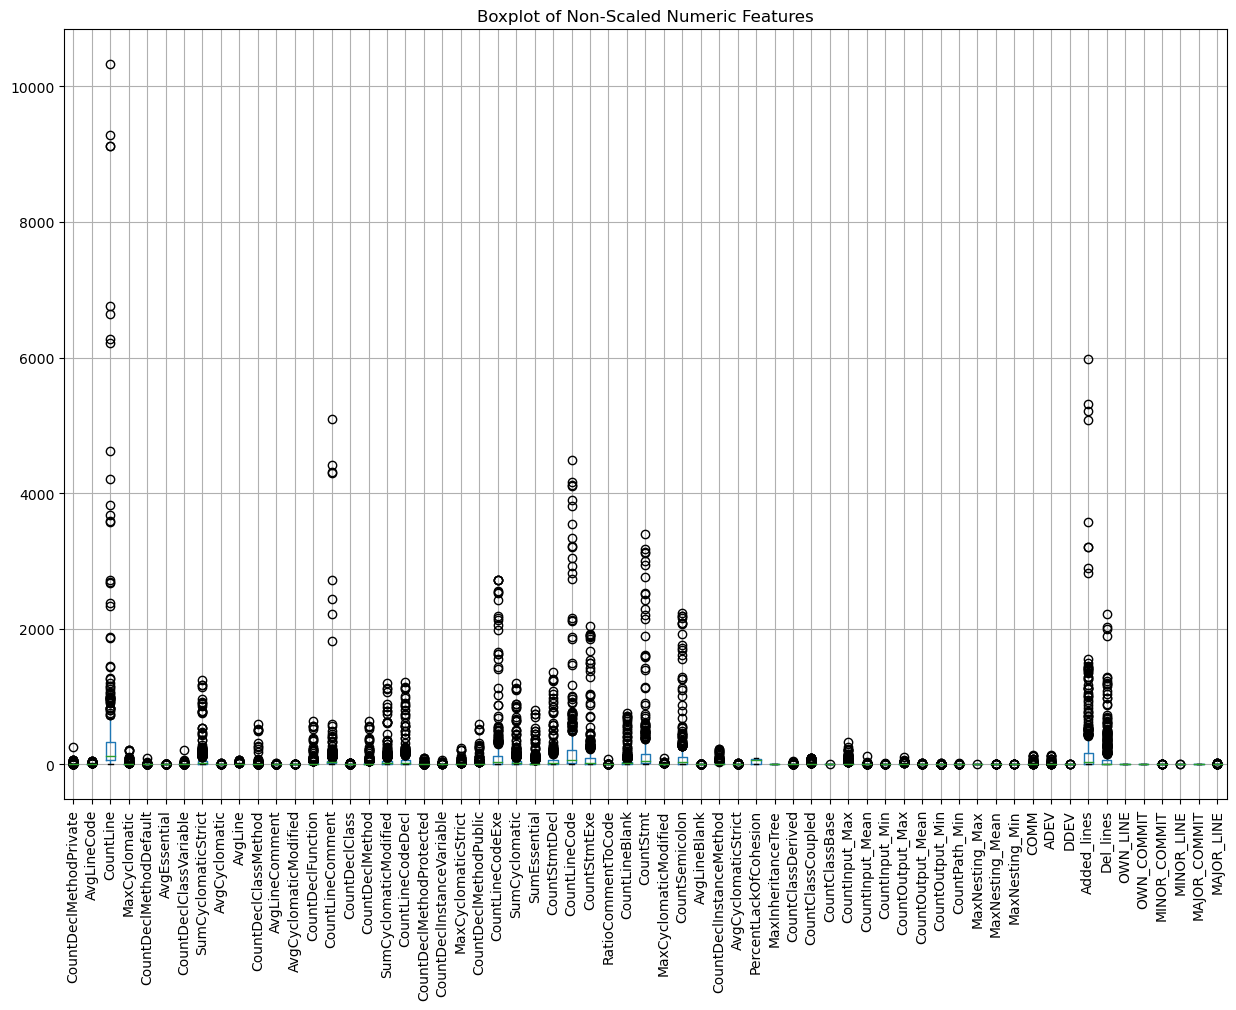

In [8]:
plt.figure(figsize=(15, 10))
X_train_balanced.drop(columns=['CountPath_Max', 'CountPath_Mean']).boxplot()
plt.title('Boxplot of Non-Scaled Numeric Features')
plt.xticks(rotation=90)
plt.show()

In [9]:
X_train_balanced_scaled.describe()

,CountDeclMethodPrivate,AvgLineCode,CountLine,MaxCyclomatic,CountDeclMethodDefault,AvgEssential,CountDeclClassVariable,SumCyclomaticStrict,AvgCyclomatic,AvgLine,...,ADEV,DDEV,Added_lines,Del_lines,OWN_LINE,OWN_COMMIT,MINOR_COMMIT,MINOR_LINE,MAJOR_COMMIT,MAJOR_LINE
count,6.560000e+02,6.560000e+02,6.560000e+02,6.560000e+02,6.560000e+02,6.560000e+02,6.560000e+02,6.560000e+02,6.560000e+02,6.560000e+02,...,656.000000,6.560000e+02,6.560000e+02,6.560000e+02,6.560000e+02,6.560000e+02,6.560000e+02,6.560000e+02,6.560000e+02,656.000000
mean,3.249433e-17,1.624717e-17,2.166289e-17,-3.520219e-17,3.249433e-17,-1.408088e-16,-5.415722e-18,-2.166289e-17,-7.175832e-17,1.083144e-16,...,0.000000,1.299773e-16,2.166289e-17,-4.332578e-17,-5.415722e-18,-4.332578e-17,2.166289e-17,-8.123583e-17,-4.332578e-17,0.000000
std,1.000763e+00,1.000763e+00,1.000763e+00,1.000763e+00,1.000763e+00,1.000763e+00,1.000763e+00,1.000763e+00,1.000763e+00,1.000763e+00,...,1.000763,1.000763e+00,1.000763e+00,1.000763e+00,1.000763e+00,1.000763e+00,1.000763e+00,1.000763e+00,1.000763e+00,1.000763
min,-2.613375e-01,-1.155814e+00,-3.605784e-01,-3.919045e-01,-1.405485e-01,-2.108488e+00,-1.884891e-01,-4.052544e-01,-8.730607e-01,-1.139695e+00,...,-0.409803,-9.636138e-01,-3.532077e-01,-3.804284e-01,-2.410933e+00,-1.405658e+00,-1.300065e-01,-1.712689e+00,-1.064087e+00,-0.518469
25%,-2.613375e-01,-5.603188e-01,-3.078204e-01,-2.906483e-01,-1.405485e-01,-1.548607e-01,-1.884891e-01,-3.717564e-01,-4.051458e-01,-6.575800e-01,...,-0.409803,-9.636138e-01,-3.532077e-01,-3.804284e-01,-8.736578e-01,-1.405658e+00,-1.300065e-01,-8.710979e-01,-1.064087e+00,-0.518469
50%,-2.613375e-01,-2.625714e-01,-2.439020e-01,-2.400203e-01,-1.405485e-01,-1.548607e-01,-1.884891e-01,-3.047604e-01,-4.051458e-01,-2.959937e-01,...,-0.254319,-8.929754e-02,-2.865878e-01,-3.601217e-01,1.348043e-01,1.923957e-01,-1.300065e-01,-2.950700e-02,-4.504893e-02,-0.518469
75%,-1.016380e-01,1.840496e-01,-3.819664e-02,-3.750799e-02,-1.405485e-01,-1.548607e-01,-8.561985e-02,-9.037314e-02,6.276907e-02,3.066502e-01,...,-0.021095,7.850187e-01,-5.071704e-02,-1.245642e-01,1.061171e+00,1.144481e+00,-1.300065e-01,8.120839e-01,9.739889e-01,0.366097
max,2.073914e+01,7.181113e+00,1.010376e+01,1.054376e+01,2.139517e+01,1.352053e+01,2.203127e+01,7.955849e+00,1.222856e+01,6.694675e+00,...,10.396283,6.030916e+00,1.039962e+01,8.656046e+00,1.114767e+00,1.144481e+00,1.299065e+01,4.178448e+00,3.012065e+00,8.769479


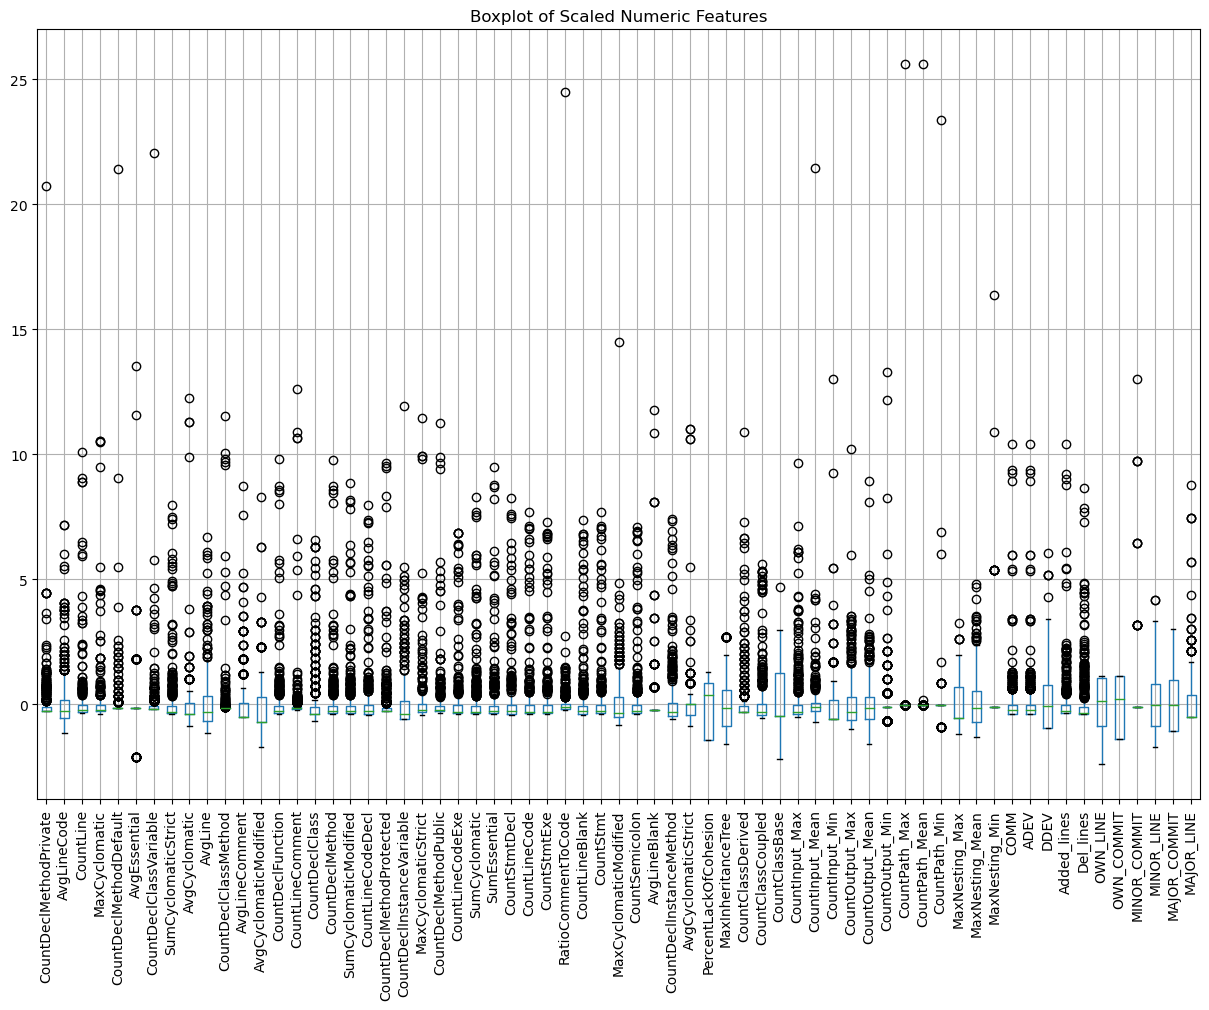

In [10]:
plt.figure(figsize=(15, 10))
X_train_balanced_scaled.boxplot()
plt.title('Boxplot of Scaled Numeric Features')
plt.xticks(rotation=90)
plt.show()